<a href="https://colab.research.google.com/github/Ruchika-11/EVA-7/blob/main/Assignment_5/Session5colab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Adding GAP layer to further reduce the number of parameters** 

### ***Target:***  
We'll now add GAP layer to further reduce the number of parameters and also stabilize the model. 
### ***Results:***  
Parameters: 8,790     
Best Train Accuracy: 98.80%       
Best Test Accuracy: 99.13%        
### ***Analysis:***  
No overfitting is seen but accuracy has come down because of the reduction in the number of parameters. We need to push the model a little to get the required accuracy.


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Using Sequential to create a small model. When `self.convblock1` is run,
        # input will first be passed to `Conv2d(1,16,3)`. The output of
        # `Conv2d(1,16,3)` will be used as the input to the `ReLU`;

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)
        ) # output_size = 26
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), stride=1, padding=0, bias=False),
            nn.ReLU(), 
            nn.BatchNorm2d(20),
            nn.Dropout(0.1)
        ) # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1)  
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(0.1)
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10), 
            nn.Dropout(0.1)
        ) # output_size = 8

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)
        ) # output_size = 6

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
             ReLU-10           [-1, 10, 24, 24]               0
      BatchNorm2d-11           [-1, 10, 24, 24]              20
          Dropout-12           [-1, 10, 24, 24]               0
        MaxPool2d-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 20,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.15242938697338104 Batch_id=468 Accuracy=89.70: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]



Test set: Average loss: 0.1148, Accuracy: 9754/10000 (97.54%)

EPOCH: 2


Loss=0.12167016416788101 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]



Test set: Average loss: 0.1109, Accuracy: 9716/10000 (97.16%)

EPOCH: 3


Loss=0.06452787667512894 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]



Test set: Average loss: 0.0597, Accuracy: 9849/10000 (98.49%)

EPOCH: 4


Loss=0.051764339208602905 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]



Test set: Average loss: 0.0495, Accuracy: 9870/10000 (98.70%)

EPOCH: 5


Loss=0.09873723983764648 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]



Test set: Average loss: 0.0432, Accuracy: 9885/10000 (98.85%)

EPOCH: 6


Loss=0.035580750554800034 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s]



Test set: Average loss: 0.0384, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.02615283988416195 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]



Test set: Average loss: 0.0398, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.041080668568611145 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]



Test set: Average loss: 0.0345, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.040898170322179794 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]



Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 10


Loss=0.09509087353944778 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0326, Accuracy: 9895/10000 (98.95%)

EPOCH: 11


Loss=0.05145227909088135 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]



Test set: Average loss: 0.0319, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.034276530146598816 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]



Test set: Average loss: 0.0297, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.052199702709913254 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:23<00:00, 20.33it/s]



Test set: Average loss: 0.0303, Accuracy: 9901/10000 (99.01%)

EPOCH: 14


Loss=0.06462941318750381 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.43it/s]



Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)

EPOCH: 15


Loss=0.018821420148015022 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:22<00:00, 20.41it/s]



Test set: Average loss: 0.0306, Accuracy: 9898/10000 (98.98%)



Text(0.5, 1.0, 'Test Accuracy')

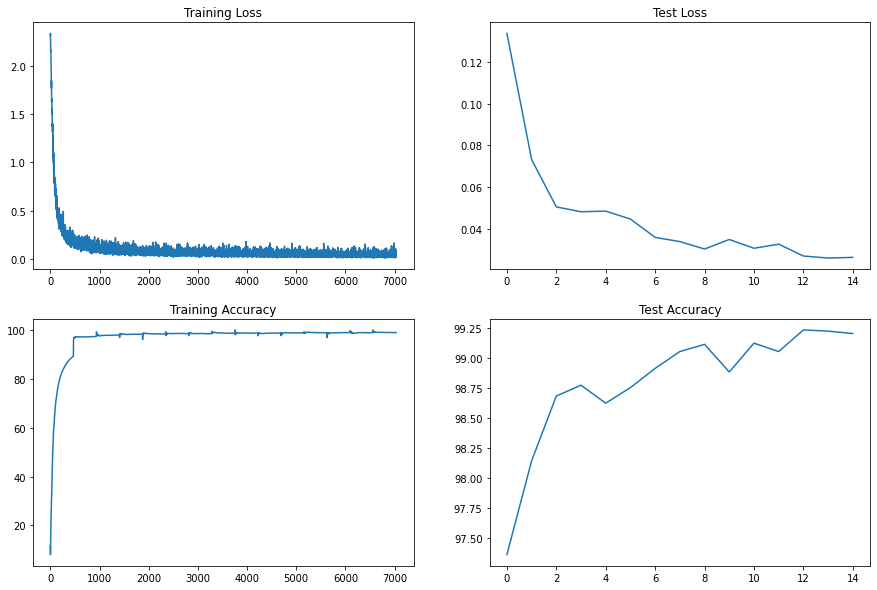

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")